In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif
/kaggle/input

# Import Libraries

In [2]:
import numpy as np 
import pandas as pd 
import itertools
import matplotlib.pyplot as plt 
import os 

from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix , classification_report  
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam , Adamax 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import L1, L2
# Import Resent Model
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

import warnings
warnings.filterwarnings('ignore')

2025-08-06 16:47:35.463102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754498855.679973      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754498855.741986      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Preprocessing

In [3]:
data = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'
labels = []
path = []

class_folders = os.listdir(os.path.join(data,"brain_tumor_dataset"))

for folder_path in class_folders:
    FolderPath = os.path.join(data,"brain_tumor_dataset",folder_path)
    FolderImages = os.listdir(FolderPath)
    for Fpath in FolderImages :
        img = os.path.join(FolderPath,Fpath)
        
        path.append(img)
        labels.append(folder_path)

df = pd.DataFrame({
    'Img_Path': path,
    'Img_Label': labels
})

In [4]:
df

,Img_Path,Img_Label
0,/kaggle/input/brain-mri-images-for-brain-tumor...,no
1,/kaggle/input/brain-mri-images-for-brain-tumor...,no
2,/kaggle/input/brain-mri-images-for-brain-tumor...,no
3,/kaggle/input/brain-mri-images-for-brain-tumor...,no
4,/kaggle/input/brain-mri-images-for-brain-tumor...,no
...,...,...
248,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
249,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
250,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
251,/kaggle/input/brain-mri-images-for-brain-tumor...,yes


## Splitting Data Into Train,Valid and Test

In [5]:
strat = df['Img_Label']
df_train, df_test = train_test_split(df,train_size = 0.8, shuffle = True, random_state = 42,stratify = strat)
print(df_train.shape, df_test.shape)

(202, 2) (51, 2)


## Distribution of Brain Tumor Disease

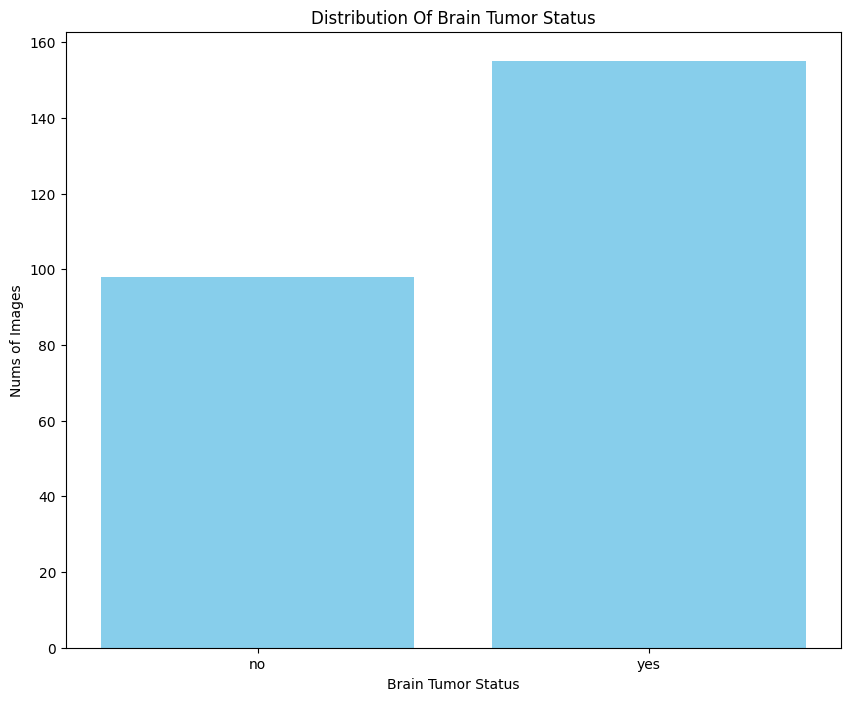

In [6]:
Tumor_Names = os.listdir(os.path.join(data,"brain_tumor_dataset"))
Tumor_Count = {Tumor_Name : len(os.listdir(os.path.join(data,Tumor_Name))) for Tumor_Name in Tumor_Names}

plt.figure(figsize = (10,8))
plt.bar(Tumor_Count.keys(),Tumor_Count.values(),color = 'skyblue')
plt.xlabel('Brain Tumor Status')
plt.ylabel('Nums of Images')
plt.title('Distribution Of Brain Tumor Status')
plt.show()

## Creating Image Data Generator

In [7]:
img_size = (224,224)
batch_size = 8 
channels = 3

tr_gen = ImageDataGenerator(
    preprocessing_function =preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
ts_gen = ImageDataGenerator(preprocessing_function =preprocess_input)

train_gen = tr_gen.flow_from_dataframe(
    df_train,
    x_col = 'Img_Path',
    y_col = 'Img_Label',
    target_size = img_size,
    class_mode= 'categorical',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    df_test,
    x_col = "Img_Path",
    y_col = "Img_Label",
    target_size = img_size,
    class_mode= "categorical",
    color_mode = 'rgb',
    shuffle = False,
    batch_size = batch_size
)

Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


## *Show Sample from Train Data*

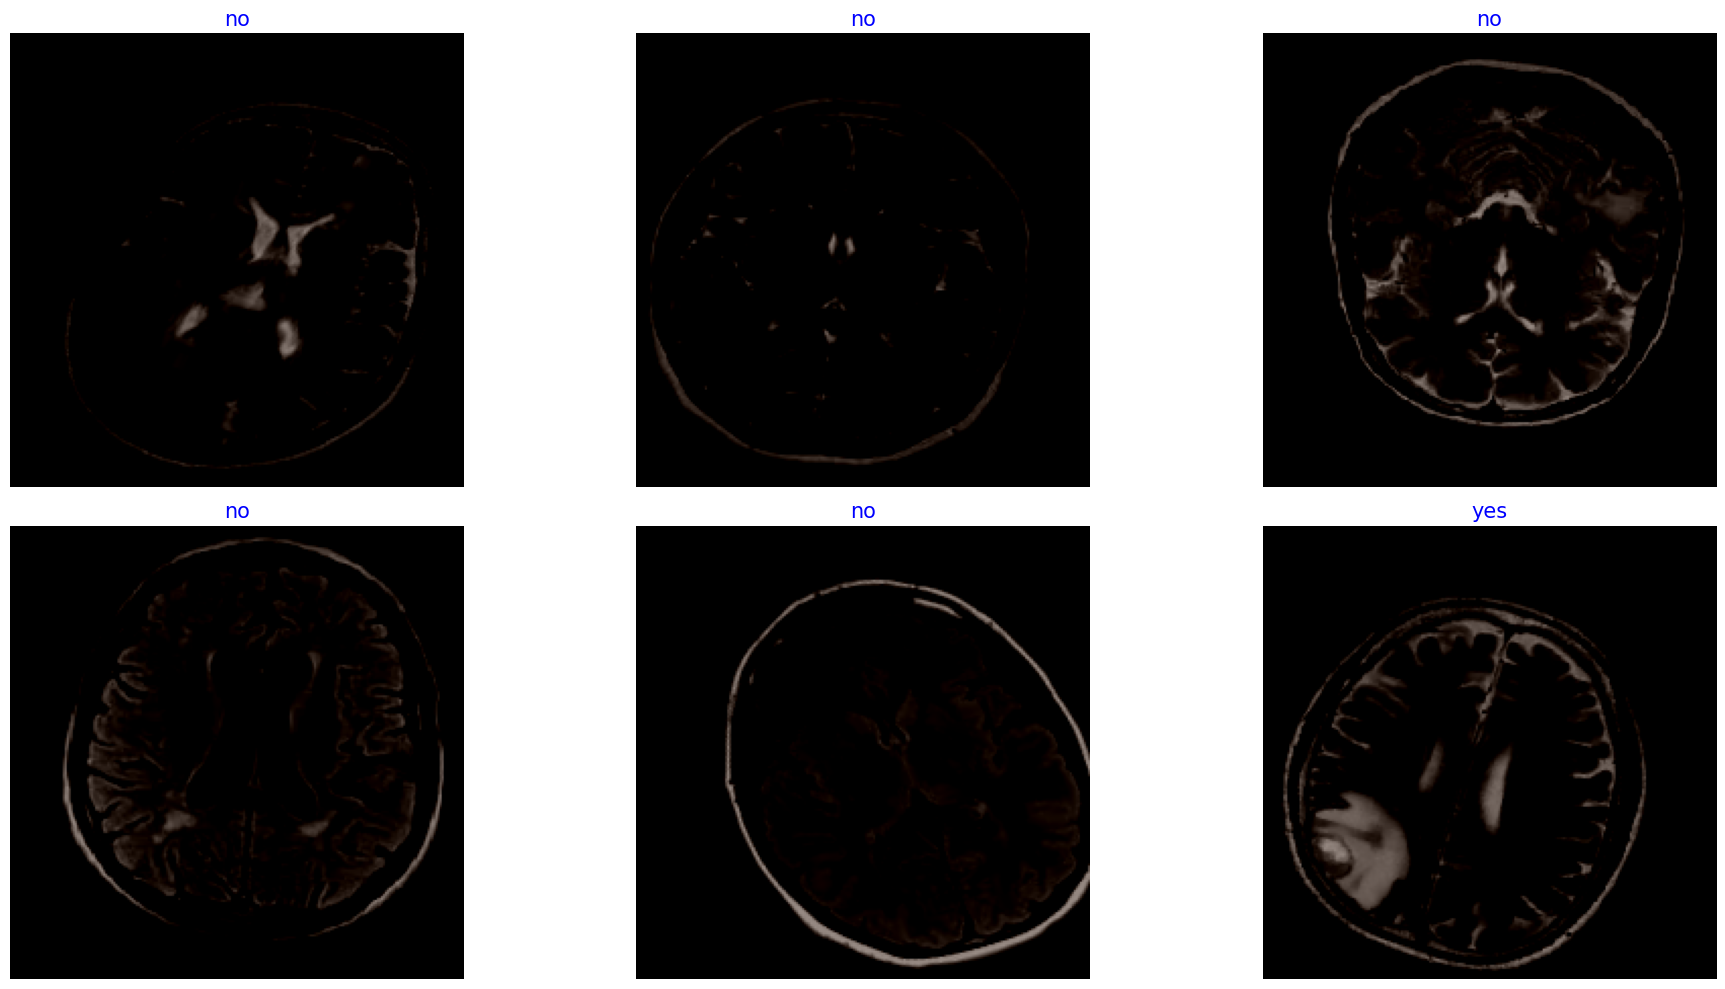

In [8]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())

images, labels = next(train_gen)

plt.figure(figsize = (20,10))

for i in range(6) :
    plt.subplot(2,3,i + 1)
    image = images[i] / 255 
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name,color = 'blue',fontsize = 15)
    plt.axis('off')
plt.tight_layout()
plt.show()

# ResNet50 Architecture
![](https://www.researchgate.net/profile/Master-Prince/publication/350421671/figure/fig1/AS:1005790324346881@1616810508674/An-illustration-of-ResNet-50-layers-architecture.png)

# Model Structure

In [9]:
img_shape = (img_size[0],img_size[1],channels)
class_count = len(classes)

# We Will use Resnet Pre-trained Model
base_model = ResNet50(include_top = False,weights= "imagenet",input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256,
    kernel_regularizer=regularizers.L2(l2=0.016),
    activity_regularizer=regularizers.L1(l1=0.006),
    bias_regularizer=regularizers.L1(l1=0.006),
    activation='relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')

])

model.compile(Adamax(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

I0000 00:00:1754498870.723346      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754498870.724071      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,120,962 (92.01 MB)

 Trainable params: 24,063,746 (91.80 MB)

 Non-trainable params: 57,216 (223.50 KB)

In [10]:
epochs = 30

history = model.fit(x = train_gen, epochs = epochs, verbose = 1, validation_data = test_gen, validation_steps = None, shuffle = False)

Epoch 1/30


I0000 00:00:1754498922.418433      66 service.cc:148] XLA service 0x7e5970004ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754498922.419354      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754498922.419379      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754498926.417072      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/26 ━━━━━━━━━━━━━━━━━━━━ 30:32 73s/step - accuracy: 0.5000 - loss: 15.2082

I0000 00:00:1754498947.479297      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.6195 - loss: 14.4122 - val_accuracy: 0.6078 - val_loss: 88.8433
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.6685 - loss: 12.0332 - val_accuracy: 0.5294 - val_loss: 362.2609
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.7632 - loss: 9.8366 - val_accuracy: 0.6667 - val_loss: 152.0048
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.7611 - loss: 8.5098 - val_accuracy: 0.6078 - val_loss: 77.3462
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.7543 - loss: 7.6049 - val_accuracy: 0.5490 - val_loss: 50.9893
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.7981 - loss: 7.0771 - val_accuracy: 0.6667 - val_loss: 34.9492
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.8048 - loss: 6.6357 - val_accuracy: 0.7647 - val_loss: 18.9756
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.8026 - loss: 6.3359 - val_accuracy: 0.5

In [11]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

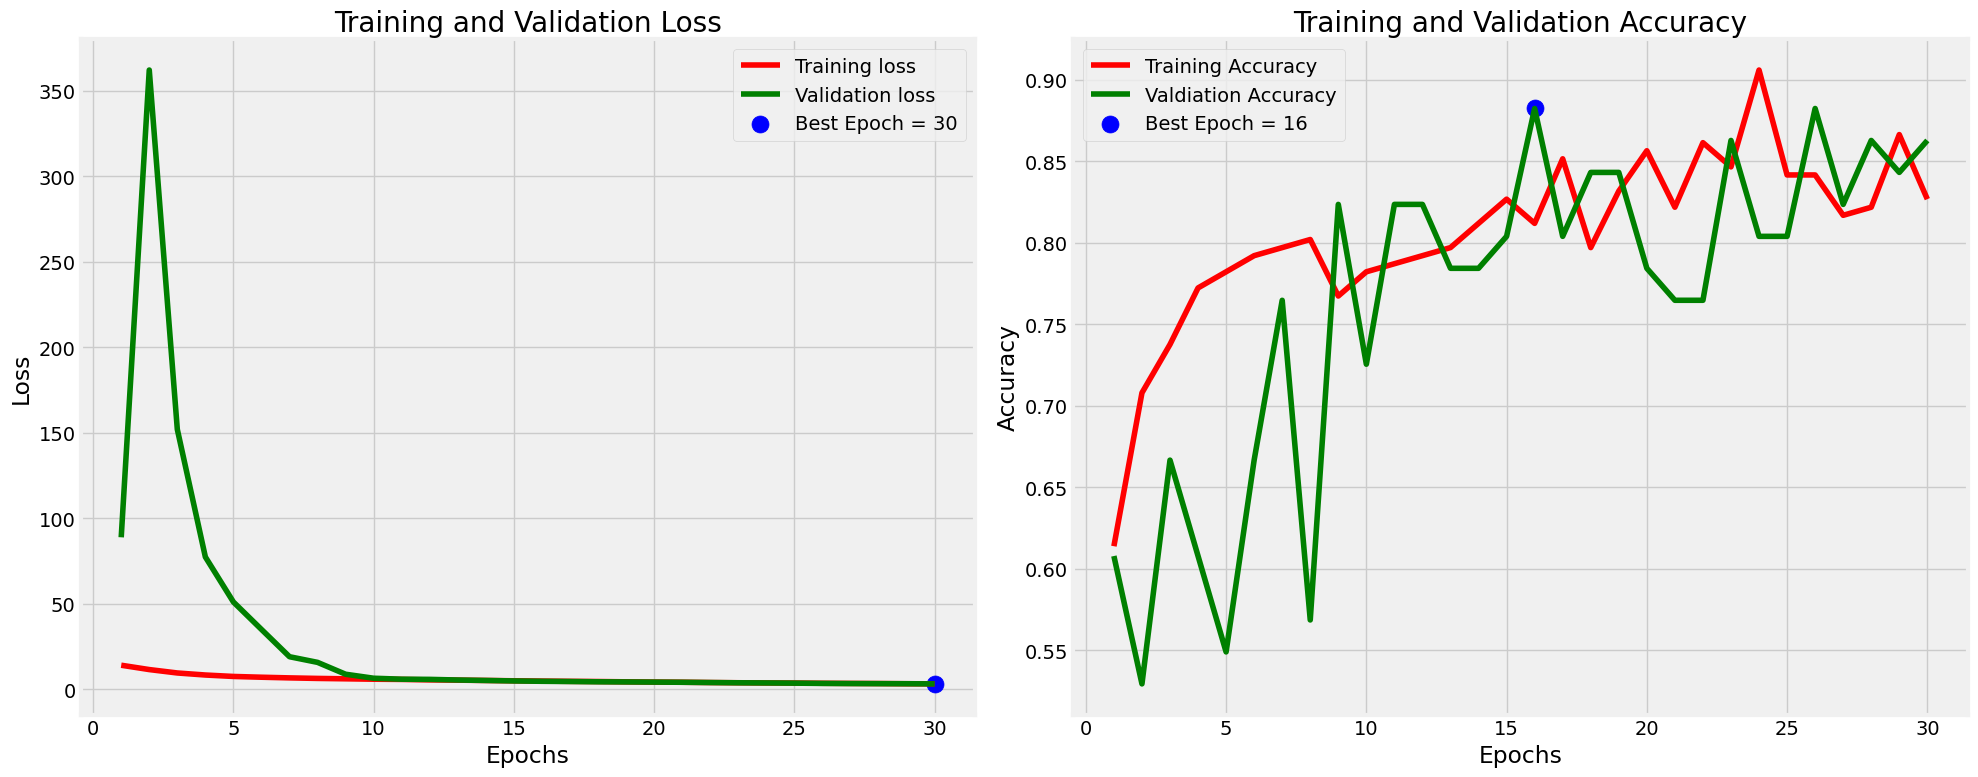

In [12]:
plt.figure(figsize = (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs, train_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs, train_acc, 'r', label ='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label ='Valdiation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate Model

In [13]:
train_score = model.evaluate(train_gen,verbose = 1)
test_score = model.evaluate(test_gen,verbose = 1)

print('Train Loss :',train_score[0])
print('Train Accuracy :',train_score[1])
print('-' * 30)
print('Test Loss :',test_score[0])
print('Test Accuracy :',test_score[1])

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.9392 - loss: 2.9725
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8316 - loss: 3.1237
Train Loss : 2.96539044380188
Train Accuracy : 0.9356435537338257
------------------------------
Test Loss : 3.077310085296631
Test Accuracy : 0.8627451062202454


## Get Predictions

In [14]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds,axis = 1)
y_pred

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 901ms/step


array([1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1])

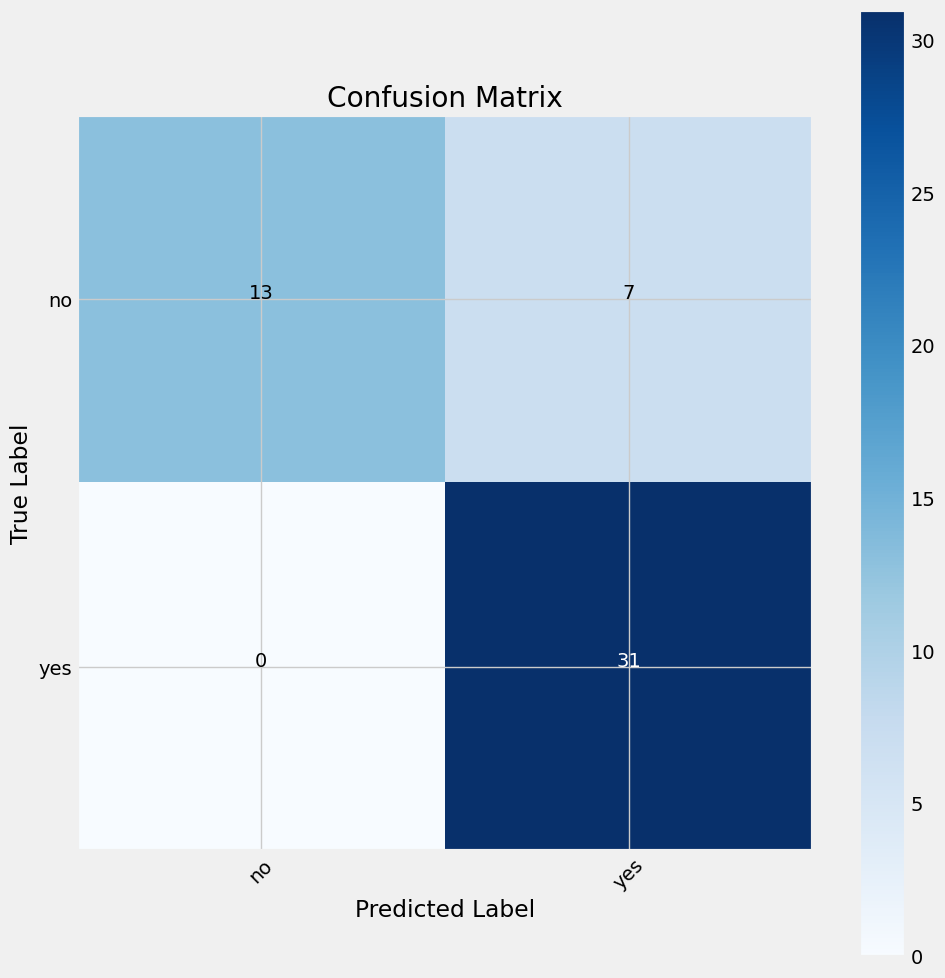

In [15]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)
# Confusion Matrix
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [16]:
# Classification Report
print(classification_report(test_gen.classes,y_pred, target_names = classes))

              precision    recall  f1-score   support

          no       1.00      0.65      0.79        20
         yes       0.82      1.00      0.90        31

    accuracy                           0.86        51
   macro avg       0.91      0.82      0.84        51
weighted avg       0.89      0.86      0.86        51



In [17]:
# Model Save
model.save('Classification_Model.h5')